# Introduction

This notebook analyse the interaction and the effects the different sociodemographics variables can have on the detection (or absence of detection) of disinformation and their impact on sharing the news.

## Import modules and functions

### Modules

In [40]:
# Import modules
import json
import csv
import itertools 

In [41]:
# Classic analysis imports
import numpy as np 
import pandas as pd 
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns

In [42]:
# Stat analysis import 
from sklearn import preprocessing
from sklearn.cluster import KMeans

import math

import scipy 
from scipy.stats import chi2_contingency
from scipy.stats import chi2

import scikit_posthocs as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats 
from statsmodels.graphics.regressionplots import *
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.anova import anova_lm
from statsmodels.stats import multicomp as mc
from statsmodels.miscmodels.ordinal_model import OrderedModel

import pingouin as pg

In [43]:
# options for the notebook
pd.set_option('display.max_colwidth',1000)
plt.style.use('seaborn')
sns.set_style('whitegrid')

## Data

### Loading

In [44]:
# Setting up the folders 
data_folder = "../data/"
analysis_results_folder = "../results/"
plots_folders = "../plots"

# Filenames
dataset_clean_filename = 'cleaned_dataset_per_subject.csv'

dataset_news_details_filename = 'details_news.csv'
dataset_news_full_filename = 'cleaned_dataset_per_news.csv'

In [46]:
# Load answers
df_subject_full = pd.read_csv('{}{}'.format(data_folder, dataset_clean_filename))

# Load news perspective
df_news_full = pd.read_csv('{}{}'.format(data_folder, dataset_news_full_filename))

# Load news details
df_news_details = pd.read_csv('{}{}'.format(data_folder, dataset_news_details_filename))

In [47]:
### Different variables
var_justification_wrong = ['tno_aclaracion_desmintiendo',
'tno_medio_desconocido',
'tno_medio_poco_fiable',
'tno_fuentes_desconocidas',
'tno_fuentes_no_confiables',
'tno_sin_fuentes',
'tno_abordaje_no_serio',
'tno_no_coherente',
'tno_titulo_sensacionalista',
'tno_imagen_sensacionalista',
'tno_no_concuerda_creencias',
'tno_no_alineado_ideologia',
'tno_otro']

var_justification_right = ['justification_avg_recuerda_leida',
'justification_avg_medio_conocido',
'justification_avg_medio_fiable',
'justification_avg_fuentes_conocidas',
'justification_avg_fuentes_confiables',
'justification_avg_abordaje_serio',
'justification_avg_coherente',
'justification_avg_concuerda_creencias',
'justification_avg_alineado_ideologia',
'justification_avg_otro']

In [56]:
df_new_to_plot = pd.melt(df_news_details, id_vars= ['news_title', 'type_news', 'topic'])
df_new_to_plot['type_metric'] = np.where(df_new_to_plot['variable'].isin(var_justification_right), 'justification', 'action')

df_new_to_plot

,news_title,type_news,topic,variable,value,type_metric
0,Stefano Montario: las mascarillas incuban el cáncer,fake_news,Science,justification_avg_aclaracion_desmintiendo,0.097561,action
1,"La OMS alerta sobre el Virus Nipah, que puede ser peor que el Covid-19",fake_news,Politics,justification_avg_aclaracion_desmintiendo,0.075472,action
2,Hantavirus. La OMS advierte al mundo del nuevo virus que viene de China,fake_news,Science,justification_avg_aclaracion_desmintiendo,0.046512,action
3,Demuestran científicamente la relación causal entre la tecnologia 5G y el COVID-19,fake_news,Technology,justification_avg_aclaracion_desmintiendo,0.115385,action
4,"El Ministerio del Interior alemán define al coronavirus como ""falsa alarma global"" en un informe filtrado a la prensa",fake_news,Politics,justification_avg_aclaracion_desmintiendo,0.033898,action
...,...,...,...,...,...,...
515,El coronavirus solo se desactiva por completo a más de 90 grados,true_news,Science,action_avg_no_accion,0.372340,action
516,El uso de la mascarilla agrava el aislamiento de las personas sordas,true_news,Science,action_avg_no_accion,0.313953,action
517,El CSIC busca una vacuna para el Covid-19 a partir del virus que erradicó la viruela,true_news,Science,action_avg_no_accion,0.512500,action
518,La Junta iniciará el lunes el reparto de menús para menores en riesgo de exclusión en Córdoba,true_news,Politics,action_avg_no_accion,0.533333,action


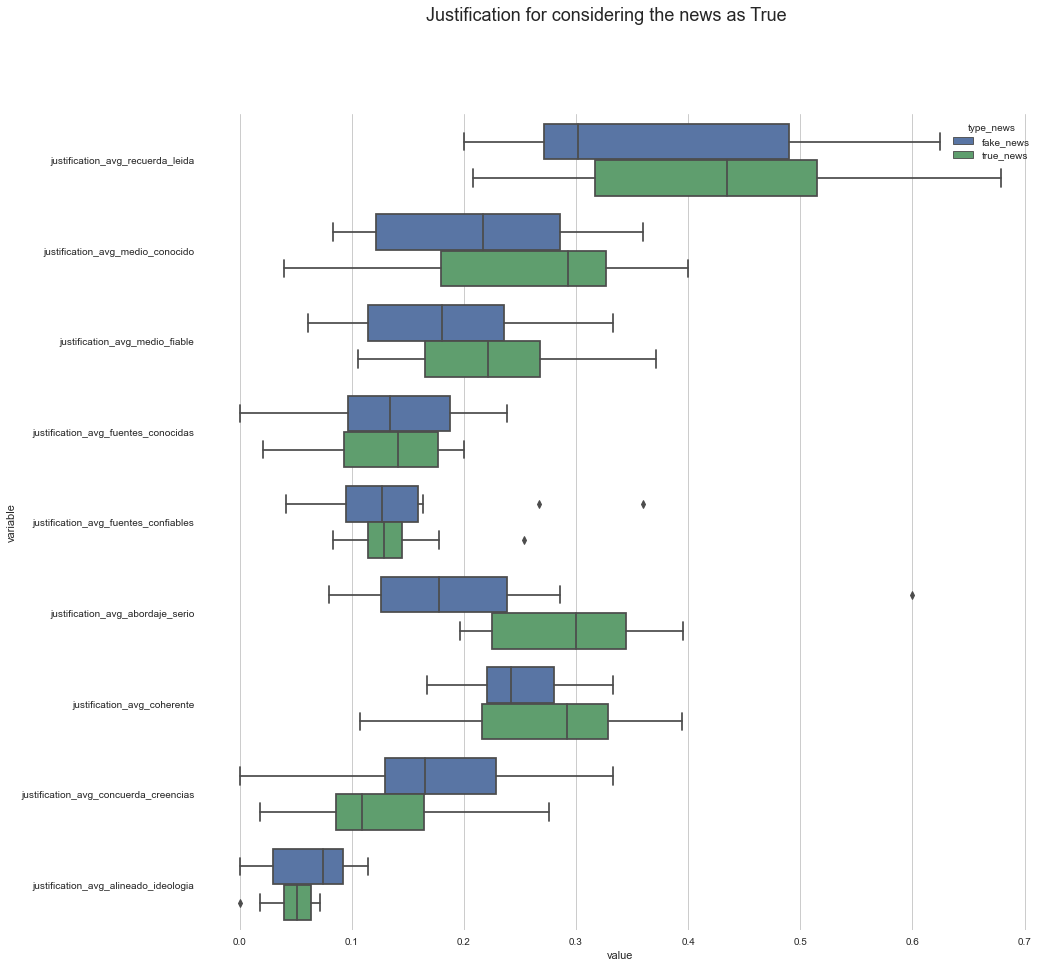

In [49]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('Justification for considering the news as True', size=18)
ax = sns.boxplot(y="variable", x="value",
                hue="type_news",

                data=df_new_to_plot[df_new_to_plot['type_metric'] == 'justification'],
                )

In [50]:
df_new_to_plot['type_metric'] = np.where(df_new_to_plot['variable'].isin(var_justification_wrong), 'justification', 'action')
fig = plt.figure(figsize=(15,15))
fig.suptitle('Justification for considering the news as Fake', size=18)
ax = sns.boxplot(y="variable", x="value",
                hue="type_news",
                data=df_new_to_plot[df_new_to_plot['type_metric'] == 'justification'],
                )

ValueError: min() arg is an empty sequence

<Figure size 1080x1080 with 0 Axes>

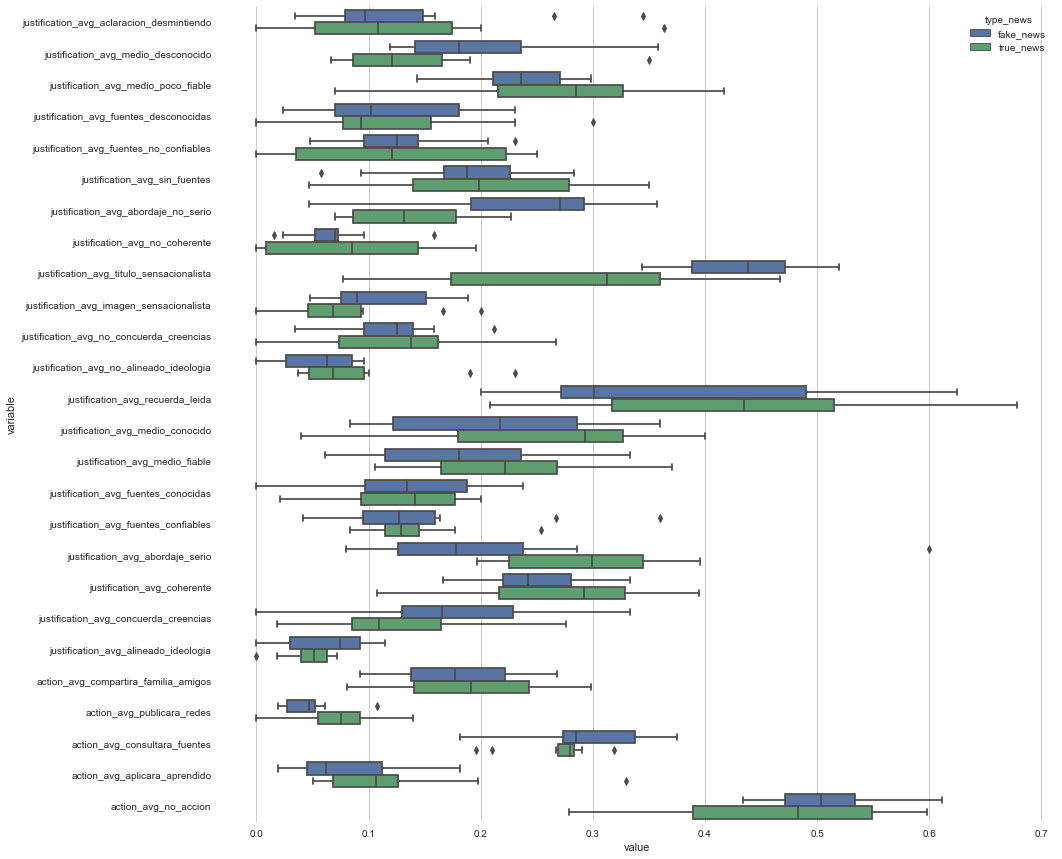

In [51]:
plt.figure(figsize=(15,15))
ax = sns.boxplot(y="variable", x="value",

                hue="type_news",

                data=df_new_to_plot[df_new_to_plot['type_metric'] == 'action'])

# Analysis

## Media consumption

In [ ]:
list_predictors = ['rutina_tele', 'rutina_internet', 'rutina_redes', 'rutina_libros', 'rutina_whatsapp', 'rutina_radio' ]

## Hypothesis about sharing news on social network

In [12]:
var_actions_f = ['faf_compartira_familia_amigos', 'faf_publicara_redes', 'faf_consultara_fuentes', 'faf_aplicara_aprendido', 'faf_no_accion']
var_actions_t = ['taf_compartira_familia_amigos', 'taf_publicara_redes', 'taf_consultara_fuentes', 'taf_aplicara_aprendido', 'taf_no_accion']
var_actions = var_actions_f + var_actions_t

When people think the news is a True News, they were asked what action they will do and if they will share it on social network. 
Here, to link with the other aspect of the research, we see how more likely the gender and the type of news elicit a tendency to share the news.


In [52]:
melt_true_fake_news = ['faf_publicara_redes', 'taf_publicara_redes', 'dm_genero']
data = df_news_details[['True news', 'Fake news', *melt_true_fake_news]]
data = data.melt(id_vars=[*melt_true_fake_news])
data = data.rename(columns={'variable': 'type_news', 'value': 'answer'})
# only get the people that had the sharing option for them 
data = data[(((data['type_news'] == 'True news') & (data['answer'] == 'Right')) | ((data['type_news'] == 'Fake news') & (data['answer'] == 'Wrong')))]

# Create sharing columns based on the appropriate original column
data.loc[data.type_news == 'True news', 'Social_Network_Sharing'] = data['taf_publicara_redes']
data.loc[data.type_news == 'Fake news', 'Social_Network_Sharing'] = data['faf_publicara_redes']

# drop the two faf and taf
data = data.drop(columns=['faf_publicara_redes', 'taf_publicara_redes', 'answer'])
data = data.dropna()
data_reg = data.copy()
X = data.loc[:, data.columns != 'Social_Network_Sharing']

#X = prepare_dummies(X, list_cat=X.columns.values)
# Add an intercept: disable by default: https://stats.stackexchange.com/questions/203740/logistic-regression-scikit-learn-vs-statsmodels
Y = data['Social_Network_Sharing'].astype('int64')
X = pd.get_dummies(X, drop_first=True)
X = sm.add_constant(X)

KeyError: "None of [Index(['True news', 'Fake news', 'faf_publicara_redes', 'taf_publicara_redes',\n       'dm_genero'],\n      dtype='object')] are in the [columns]"

# Hypothesis about sharing news on social network and the reason why they were considered as False

Here we use the answer given by people that think the news was wrong to see if these caracteristics influence  the propension for people to share them. 

In [39]:
# In case the subject thinks it is a Fake News (regardless of the news)
var_justification_wrong = ['tno_aclaracion_desmintiendo',
'tno_medio_desconocido',
'tno_medio_poco_fiable',
'tno_fuentes_desconocidas',
'tno_fuentes_no_confiables',
'tno_sin_fuentes',
'tno_abordaje_no_serio',
'tno_no_coherente',
'tno_titulo_sensacionalista',
'tno_imagen_sensacionalista',
'tno_no_concuerda_creencias',
'tno_no_alineado_ideologia',
'tno_otro']

# First creating a score based on the type of news rather than by subject

## Creating it for the fake news
df_fake = df[['fake_news', *var_justification_wrong]]
df_fake = df_fake.replace({True: 1, False: 0})
df_fake = df_fake.groupby('fake_news').agg('mean')
df_fake.columns = ['avg_' + '_'.join(i.split('_')[1:]) for i in df_fake.columns]
df_fake['type_news'] = 'Fake'

## Creating for the true news
df_true = df[['true_news', *var_justification_wrong]]
df_true = df_true.replace({True: 1, False: 0})
df_true = df_true.groupby('true_news').agg('mean')
df_true.columns = ['avg_' + '_'.join(i.split('_')[1:]) for i in df_true.columns]
df_true['type_news'] = 'True'


## Append the two dataframe
df_avg_justification_wrong = df_fake
df_avg_justification_wrong = df_avg_justification_wrong.append(df_true)
df_avg_justification_wrong = df_avg_justification_wrong.reset_index().rename(columns={'index': 'news_title'})

value_avg_justification = df_avg_justification_wrong.columns[1:-1].values

NameError: name 'df_news' is not defined

In [17]:
df_to_plot = df_avg_justification_wrong.melt(id_vars=['news_title', 'type_news'])
plt.figure(figsize=(15,15))
ax = sns.boxplot(data=df_to_plot, y='variable', x='value', hue='type_news')

NameError: name 'df_avg_justification_wrong' is not defined

In [18]:
melt_true_fake_news = ['faf_publicara_redes', 'taf_publicara_redes'] 

data = df[['fake_news', 'true_news', 'True news', 'Fake news', *melt_true_fake_news]]
data = data.melt(id_vars=['fake_news', 'true_news', *melt_true_fake_news])
data = data.rename(columns={'variable': 'type_news', 'value': 'answer'})
# only get the people that had the sharing option for them 
data = data[(((data['type_news'] == 'True news') & (data['answer'] == 'Right')) | ((data['type_news'] == 'Fake news') & (data['answer'] == 'Wrong')))]
data.drop(columns = ['type_news', 'answer'], inplace=True)


df_fake_title = data.drop(columns=['true_news']).melt(id_vars=[*melt_true_fake_news])#.drop(columns=['variable'])
df_fake_title = df_fake_title.rename(columns={'value': 'news_title', 'faf_publicara_redes': 'shared_network'})
#df_fake_title = df_fake_title.merge(df_avg_justification_wrong, on='news_title')
df_fake_title.drop(columns=['taf_publicara_redes'], inplace=True)

df_true_title = data.drop(columns=['fake_news']).melt(id_vars=[*melt_true_fake_news])#.drop(columns=['variable'])
df_true_title = df_true_title.rename(columns={'value': 'news_title', 'taf_publicara_redes': 'shared_network'})
#df_true_title = df_true_title.merge(df_avg_justification_wrong, on='news_title')
df_true_title.drop(columns=['faf_publicara_redes'], inplace=True)

data = df_fake_title
data = data.append(df_true_title)
data = data.merge(df_avg_justification_wrong, on='news_title').drop(columns=['variable'])
#data.dropna(subset = ["shared_network"], inplace=True)

NameError: name 'df' is not defined

In [19]:
#data_lg = data[['shared_network', 'avg_no_coherente', 'type_news']]

X = data.loc[:, data.columns != 'shared_network']

#X = prepare_dummies(X, list_cat=X.columns.values)
# Add an intercept: disable by default: https://stats.stackexchange.com/questions/203740/logistic-regression-scikit-learn-vs-statsmodels
Y = data['shared_network'].astype('int64')
X = pd.get_dummies(X, drop_first=True)
X = sm.add_constant(X)

NameError: name 'data' is not defined

In [20]:
# building the model and fitting the data
#log_reg = sm.Logit(Y, X).fit()
#formula = 'shared_network ~ ' + '+'.join([col for col in data.columns if col != 'shared_network']) #+ ' + ' + ' * '.join(['avg_imagen_sensacionalista', 'type_news'])
formula = 'shared_network ~ ' + ' + '.join(['avg_imagen_sensacionalista', 'type_news'])
m1 = smf.logit(formula=formula, data=data).fit()

NameError: name 'data' is not defined

In [21]:
print(m1.summary())

NameError: name 'm1' is not defined

# Sources

## Packages

 * [mord](https://github.com/fabianp/mord): Pedregosa, Fabian, Francis Bach, and Alexandre Gramfort. "On the consistency of ordinal regression methods." The Journal of Machine Learning Research 18.1 (2017) JMLR.
 * [pingouin](https://pingouin-stats.org/): Vallat, R. (2018). Pingouin: statistics in Python. Journal of Open Source Software, 3(31), 1026, https://doi.org/10.21105/joss.01026
 * statsmodels: [https://www.statsmodels.org/stable/index.html#citation](https://www.statsmodels.org/stable/index.html#citation)
    > @inproceedings{seabold2010statsmodels,title={statsmodels: Econometric and statistical modeling with python}, author={Seabold, Skipper and Perktold, Josef}, booktitle={9th Python in Science Conference},year={2010},}
 * [scipy](https://www.scipy.org/citing.html): Pauli Virtanen, Ralf Gommers, Travis E. Oliphant, Matt Haberland, Tyler Reddy, David Cournapeau, Evgeni Burovski, Pearu Peterson, Warren Weckesser, Jonathan Bright, Stéfan J. van der Walt, Matthew Brett, Joshua Wilson, K. Jarrod Millman, Nikolay Mayorov, Andrew R. J. Nelson, Eric Jones, Robert Kern, Eric Larson, CJ Carey, İlhan Polat, Yu Feng, Eric W. Moore, Jake VanderPlas, Denis Laxalde, Josef Perktold, Robert Cimrman, Ian Henriksen, E.A. Quintero, Charles R Harris, Anne M. Archibald, Antônio H. Ribeiro, Fabian Pedregosa, Paul van Mulbregt, and SciPy 1.0 Contributors. (2020) SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python. Nature Methods, 17(3), 261-272.
 * [scikit-learn](https://scikit-learn.org/stable/): Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011) (publisher link)

## Articles

*   Bürkner, P.-C., & Vuorre, M. (2019). Ordinal Regression Models in Psychology: A Tutorial. Advances in Methods and Practices in Psychological Science, 77–101. https://doi.org/10.1177/2515245918823199

* Midi, H., Sarkar, S. K., & Rana, S. (2010). Collinearity diagnostics of binary logistic regression model. Journal of Interdisciplinary Mathematics, 13(3), 253–267. doi:10.1080/09720502.2010.10700699 

* Kuha, J., & Mills, C. (n.d.). On Group Comparisons with Logistic Regression Models. 24.
